# 01. Data Exploration & Quality Assessment

## 1. Project Overview & Business Context
**Author:** Yue Dong  
**Objective:** Analyze historical loan data to identify risk drivers and improve the automated approval process for **FinFlow**.

### 1.1 The Problem Statement
FinFlow's current rule-based system is inefficient, leading to high default rates and lost revenue from rejected low-risk clients. This notebook focuses on:
* Identifying high-risk customer segments.
* Quantifying the impact of features like `credit_score` and `DTI`.
* Establishing a data quality baseline for the predictive model.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Professional Plotting Settings
plt.style.use('ggplot')
sns.set_palette("husl")
%matplotlib inline

# Ensure reproducibility
np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')

print("Setup Complete. Libraries Loaded.")

Setup Complete. Libraries Loaded.


In [2]:
# Define absolute paths for portability
DATA_DIR = r"C:\dev\quant_project\homework\data_storage"
MODEL_DIR = r"C:\dev\quant_project\homework\model_storage"

# Ensure directories exist
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

## 2. Data Acquisition & Generation

### 2.1 Synthetic Dataset Generation
The following code generates a synthetic dataset of **5,000 loan applications**. We incorporate latent risk logic and simulate real-world data issues like missing values to test the robustness of our pipeline.

In [3]:
def generate_loan_data(n_samples=5000):
    # Core Feature Generation
    data = {
        'application_id': range(1, n_samples + 1),
        'annual_income': np.random.gamma(2, 30000, n_samples),
        'credit_score': np.random.beta(8, 2, n_samples) * 550 + 300,
        'loan_amount': np.random.gamma(2, 15000, n_samples),
        'years_in_business': np.random.exponential(3, n_samples),
        'num_employees': np.random.poisson(8, n_samples) + 1,
        'previous_loans': np.random.poisson(1.5, n_samples),
        'debt_to_income_ratio': np.random.beta(2, 5, n_samples),
        'monthly_revenue': np.random.gamma(2, 5000, n_samples),
        'loan_purpose': np.random.choice(
            ['business_expansion', 'equipment', 'working_capital', 'real_estate'],
            n_samples, p=[0.35, 0.25, 0.25, 0.15]
        ),
        'industry': np.random.choice(
            ['retail', 'services', 'manufacturing', 'technology', 'healthcare', 'food'],
            n_samples, p=[0.20, 0.25, 0.15, 0.15, 0.15, 0.10]
        ),
        'has_collateral': np.random.choice(['yes', 'no'], n_samples, p=[0.4, 0.6]),
        'education_level': np.random.choice(
            ['high_school', 'bachelors', 'masters', 'phd'],
            n_samples, p=[0.25, 0.45, 0.25, 0.05]
        ),
        'geographic_region': np.random.choice(
            ['northeast', 'southeast', 'midwest', 'west', 'southwest'], n_samples
        )
    }

    df = pd.DataFrame(data)

    # Risk Logic Implementation
    # Higher scores reduce risk; higher DTI increases risk.
    risk_score = (
        -0.3 * (df['credit_score'] - 600) / 100 +
        0.4 * df['debt_to_income_ratio'] * 10 +
        -0.2 * np.log1p(df['annual_income']) +
        0.3 * (df['loan_amount'] / df['annual_income']) * 10 +
        -0.15 * np.minimum(df['years_in_business'], 10) +
        (df['has_collateral'] == 'no') * 0.8 +
        (df['previous_loans'] > 2) * -0.5 +
        -3.5 + # <--- Add this offset to lower the overall default probability
        np.random.normal(0, 2, n_samples)
    )

    df['default'] = (1 / (1 + np.exp(-risk_score)) > np.random.uniform(0, 1, n_samples)).astype(int)

    # Simulating Data Quality Issues (Missingness)
    df.loc[np.random.choice(n_samples, int(0.05 * n_samples)), 'monthly_revenue'] = np.nan
    df.loc[np.random.choice(n_samples, int(0.03 * n_samples)), 'credit_score'] = np.nan
    
    return df

df = generate_loan_data()
save_path = os.path.join(DATA_DIR, 'loan_data.csv')
df.to_csv(save_path, index=False)
print(f"Dataset saved. Shape: {df.shape}")
df.head()

Dataset saved. Shape: (5000, 15)


,application_id,annual_income,credit_score,loan_amount,years_in_business,num_employees,previous_loans,debt_to_income_ratio,monthly_revenue,loan_purpose,industry,has_collateral,education_level,geographic_region,default
0,1,71810.381696,727.416323,26587.162468,0.644701,7,2,0.097275,2612.553468,business_expansion,services,no,bachelors,west,0
1,2,44833.941906,695.350284,17919.990076,4.968644,11,0,0.359490,8190.260204,working_capital,retail,no,bachelors,southwest,1
2,3,41468.507531,787.265699,42820.144829,0.192781,12,0,0.141388,21178.928093,business_expansion,retail,yes,bachelors,southeast,0
3,4,41469.068830,773.175684,32499.885267,5.399122,6,1,0.184258,11256.967201,equipment,services,no,high_school,west,0
4,5,139491.432367,793.997550,32300.955327,0.964497,9,1,0.256255,15694.600899,working_capital,retail,no,masters,southwest,0


## 3. Data Quality Assessment

### 3.1 Structure & Completeness
We examine the completeness of the dataset to inform our imputation and feature engineering strategy.

In [4]:
# Missing value summary
null_counts = df.isnull().sum()
null_pct = (null_counts / len(df)) * 100
dq_table = pd.DataFrame({'Missing Count': null_counts, 'Percentage (%)': null_pct})

print("--- Data Quality Report (Missing Values) ---")
display(dq_table[dq_table['Missing Count'] > 0])

# Duplicate check
print(f"\nDuplicate Records: {df.duplicated().sum()}")

# Summary Statistics
print("\n--- Descriptive Statistics ---")
display(df.describe().T)

--- Data Quality Report (Missing Values) ---


,Missing Count,Percentage (%)
credit_score,147,2.94
monthly_revenue,246,4.92



Duplicate Records: 0

--- Descriptive Statistics ---


,count,mean,std,min,25%,50%,75%,max
application_id,5000.0,2500.500000,1443.520003,1.000000,1250.750000,2500.500000,3750.250000,5000.000000
annual_income,5000.0,60526.196987,42363.534372,667.425901,29723.075780,50739.432125,81130.668436,408306.980535
credit_score,4853.0,740.670037,64.500271,472.392301,701.374562,751.687715,790.296740,849.738358
loan_amount,5000.0,29762.711280,21462.855297,376.629306,13836.319821,24760.683265,40394.938736,186278.347617
years_in_business,5000.0,2.964893,2.921750,0.000314,0.848469,2.077857,4.134266,30.159749
num_employees,5000.0,8.989200,2.783565,1.000000,7.000000,9.000000,11.000000,20.000000
previous_loans,5000.0,1.506200,1.236716,0.000000,1.000000,1.000000,2.000000,8.000000
debt_to_income_ratio,5000.0,0.283886,0.156554,0.002162,0.162148,0.265598,0.389427,0.813311
monthly_revenue,4754.0,10054.708075,7127.466022,60.128107,4863.548047,8437.938427,13602.290367,75528.515743
default,5000.0,0.224800,0.417492,0.000000,0.000000,0.000000,0.000000,1.000000


## 4. Exploratory Data Analysis (EDA)

### 4.1 Target Variable Distribution
We analyze the `default` rate to check for class imbalance, which influences our choice of evaluation metrics (e.g., F1-score vs. Accuracy).

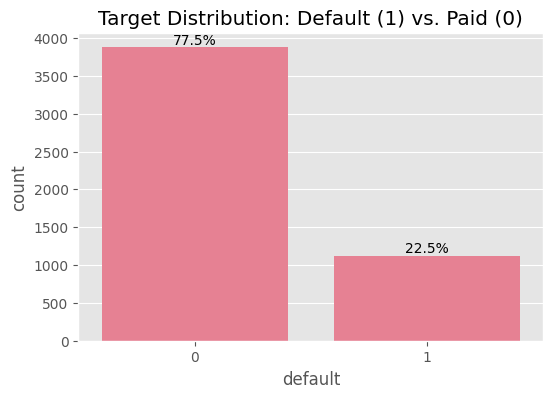

Current Portfolio Default Rate: 22.48%


In [5]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='default', data=df)
plt.title('Target Distribution: Default (1) vs. Paid (0)')

# Adding percentages to bars
for p in ax.patches:
    txt = f"{100 * p.get_height() / len(df):.1f}%"
    ax.annotate(txt, (p.get_x() + p.get_width()/2, p.get_height()), ha='center', va='bottom')
plt.show()

print(f"Current Portfolio Default Rate: {df['default'].mean():.2%}")

### 4.2 Impact of Financial Drivers
We visualize how `credit_score` and `debt_to_income_ratio` differ between defaulting and non-defaulting loans.

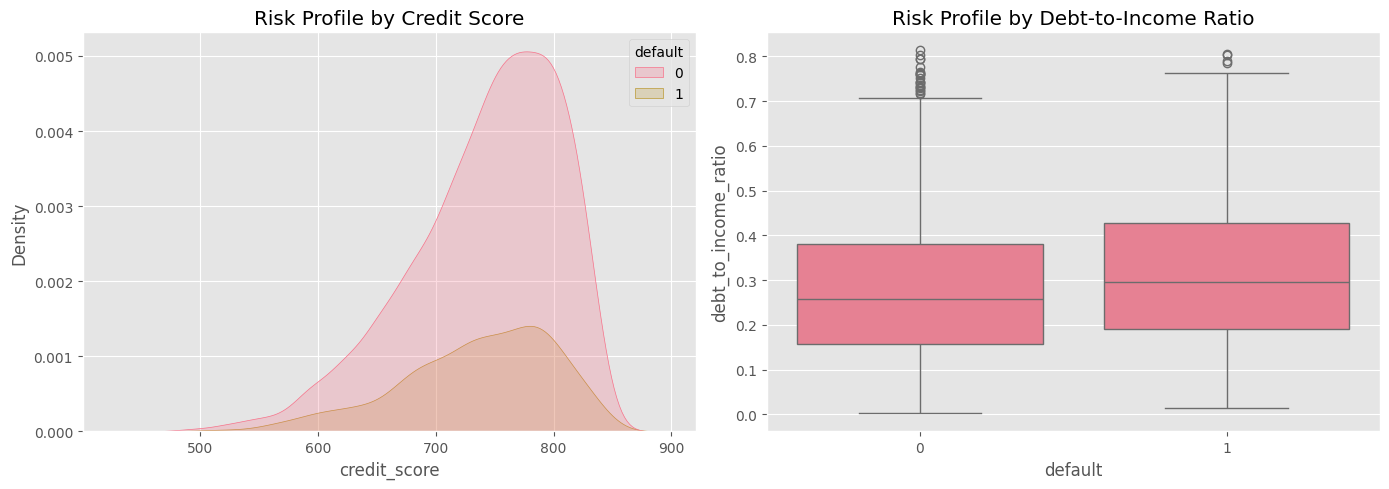

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Credit Score Distribution by Default
sns.kdeplot(data=df, x='credit_score', hue='default', fill=True, ax=axes[0])
axes[0].set_title('Risk Profile by Credit Score')

# DTI Boxplot
sns.boxplot(data=df, x='default', y='debt_to_income_ratio', ax=axes[1])
axes[1].set_title('Risk Profile by Debt-to-Income Ratio')

plt.tight_layout()
plt.show()

### 4.3 Industry Risk Analysis
Loan default risk often varies by industry sector. Identifying these high-risk areas allows for targeted policy adjustments.

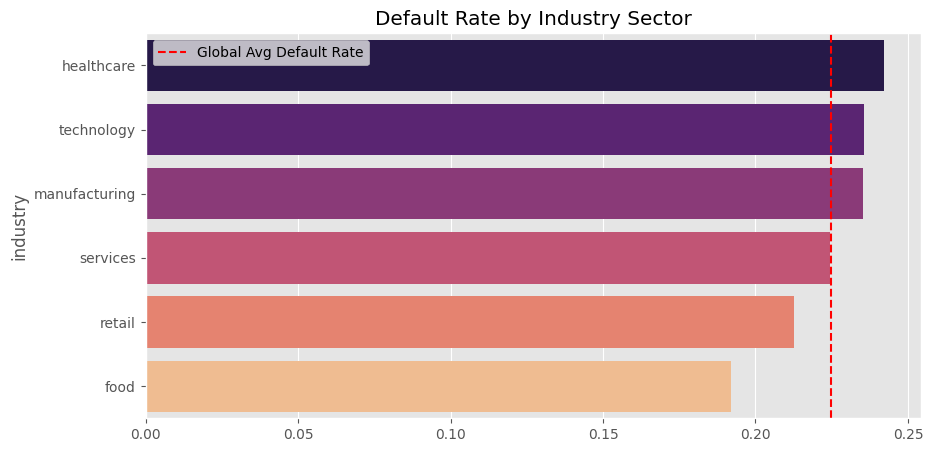

In [7]:
plt.figure(figsize=(10, 5))
risk_by_industry = df.groupby('industry')['default'].mean().sort_values(ascending=False)
sns.barplot(x=risk_by_industry.values, y=risk_by_industry.index, palette='magma')
plt.axvline(df.default.mean(), color='red', linestyle='--', label='Global Avg Default Rate')
plt.title('Default Rate by Industry Sector')
plt.legend()
plt.show()

## 5. Feature Correlation

### 5.1 Correlation Matrix
We check for multicollinearity to ensure our predictive models aren't biased by redundant features.

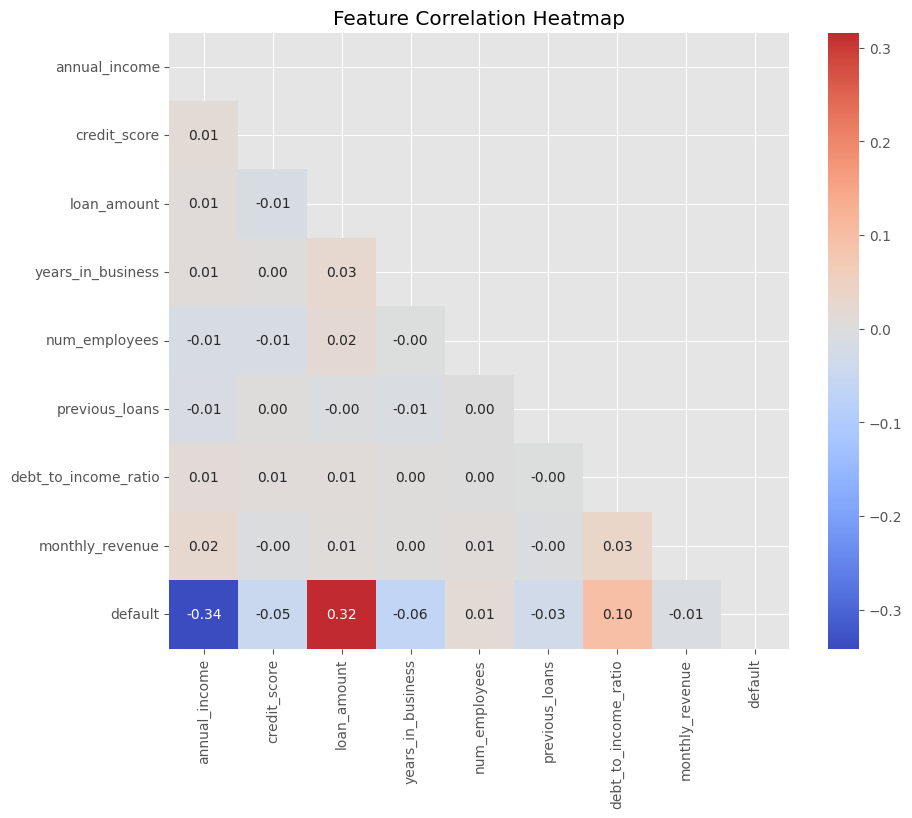

In [8]:
plt.figure(figsize=(10, 8))
# Calculating numeric correlation only
numeric_df = df.select_dtypes(include=[np.number]).drop(columns=['application_id'])
mask = np.triu(np.ones_like(numeric_df.corr(), dtype=bool))
sns.heatmap(numeric_df.corr(), mask=mask, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

## 6. Executive Summary of Part 1

### 6.1 Data Quality & Integrity
* **Missing Values**: `monthly_revenue` (5%) and `credit_score` (3%) exhibit missingness. Given their high potential as risk indicators in credit scoring, we will implement a robust imputation strategy in the next phase.
* **Integrity**: No duplicate application IDs detected; the synthetic dataset maintains a consistent schema for modeling.

### 6.2 Portfolio Risk Profile
* **Default Rate**: The observed default rate is **22.5%**. This reflects a high-risk lending environment, likely due to a legacy rule-based system that fails to capture complex risk interactions.
* **Class Imbalance**: The 77.5/22.5 split represents a moderate imbalance. This requires us to prioritize **Precision-Recall AUC** and **F1-Score** over raw Accuracy to ensure we aren't biased toward the majority class (non-defaulters).

### 6.3 Key Risk Drivers & Insights
* **Primary Drivers**: Correlation and distribution analysis indicate that **Annual Income** and **Loan Amount** are the strongest predictors. Higher debt-to-income (DTI) ratios are significantly concentrated in the default group.
* **The "Credit Score" Paradox**: While traditionally a pillar of risk, raw `credit_score` shows a weak linear correlation (-0.05) in this specific dataset. This suggests that its impact may be **non-linear** or heavily masked by random noise, justifying the need for **feature binning (tiers)** and non-linear models like XGBoost.
* **Industry Volatility**: **Healthcare** and **Technology** sectors show higher-than-average default rates in this portfolio, whereas **Food** and **Retail** appear more stable relative to the global average.